In [1]:
import numpy as np
import pandas

from graphing.sampling_graphs import create_sample_distribution_graph_groupings, create_grouping_influence_graph, create_sample_distribution_graph
from learning.grouped_learning import Berta
from learning.grouped_linear_regression import Gustav
from model.datasets import Datasets, SynDataset
from model.synth_data_factory import SyntheticDataBuilder
from sampling.from_tests_sampler import FromTestsSamplingStrategy
from sampling.group_sampling.hamming_group_sampling_strategy import HammingGroupSamplingStrategy
from sampling.random_sampling.better_random_sampling_strategy import BetterRandomSamplingStrategy
from sampling.random_sampling.distance_sampling_strategy import DistanceSamplingStrategy
from sampling.sampler import Sampler
from testing.grouped_tester import GroupedTester
from testing.grouped_tester_flipping import GroupedTesterSigns
from testing.tester import Tester
from util.util import get_samples_with_results, get_regression_metricts, make_df_representation
from sampling.group_sampling.mutex_aware_group_sampling_strategy import IndependentFeatureGroupSamplingStrategy
from util.util import get_samples_with_results_full
import logging

numba_logger = logging.getLogger('numba')
numba_logger.setLevel(logging.WARNING)
pandas.set_option("display.max_columns", None)
%load_ext autoreload
%autoreload 2

# Data Generation

In [2]:
data_builder = SyntheticDataBuilder(
    parameters=10,
    influential_parameters=1,
    mutex_groups=[],
    mutex_required=[],
    constrains=0,
    interactions=0
)
data_builder.print_overview()
influential_params = [i - 1 for i in data_builder.influential_features]
vm, test_strategy = data_builder.get_vm(), data_builder.get_testing_strategy()
# vm, test_strategy = Datasets().get_dataset('javagc')


Synthetic data generation:
 Generated 10 Parameters
 0 mutex groups
 0 Constrains
 Influential features: [9]
 Weightings: [2, 1, -2, -4, -1, 1, 4, -4, 112, 4]
 Interacting features:


DEBUG:root:Distance: 7
DEBUG:root:Distance: 0
DEBUG:root:Distance: 9
DEBUG:root:Distance: 3
DEBUG:root:Distance: 3
DEBUG:root:Distance: 5
DEBUG:root:Distance: 5
DEBUG:root:Distance: 2
DEBUG:root:Distance: 4
DEBUG:root:Distance: 4
DEBUG:root:Distance: 1
DEBUG:root:Distance: 4
DEBUG:root:Distance: 5
DEBUG:root:Distance: 2
DEBUG:root:Distance: 2
DEBUG:root:Distance: 1
DEBUG:root:Distance: 0
DEBUG:root:Distance: 7
DEBUG:root:Distance: 9
DEBUG:root:Distance: 6
DEBUG:root:Distance: 2
DEBUG:root:Distance: 5
DEBUG:root:Distance: 0
DEBUG:root:Distance: 4
DEBUG:root:Distance: 5
DEBUG:root:Distance: 4
DEBUG:root:Distance: 0
DEBUG:root:Distance: 1
DEBUG:root:Distance: 9
DEBUG:root:Distance: 3
DEBUG:root:Distance: 3
DEBUG:root:Distance: 1
DEBUG:root:Distance: 0
DEBUG:root:Distance: 2
DEBUG:root:Distance: 7
DEBUG:root:Distance: 2
DEBUG:root:Distance: 5
DEBUG:root:Distance: 8
DEBUG:root:Distance: 9
DEBUG:root:Distance: 1
DEBUG:root:Distance: 6
DEBUG:root:Distance: 2
DEBUG:root:Distance: 0
DEBUG:root:

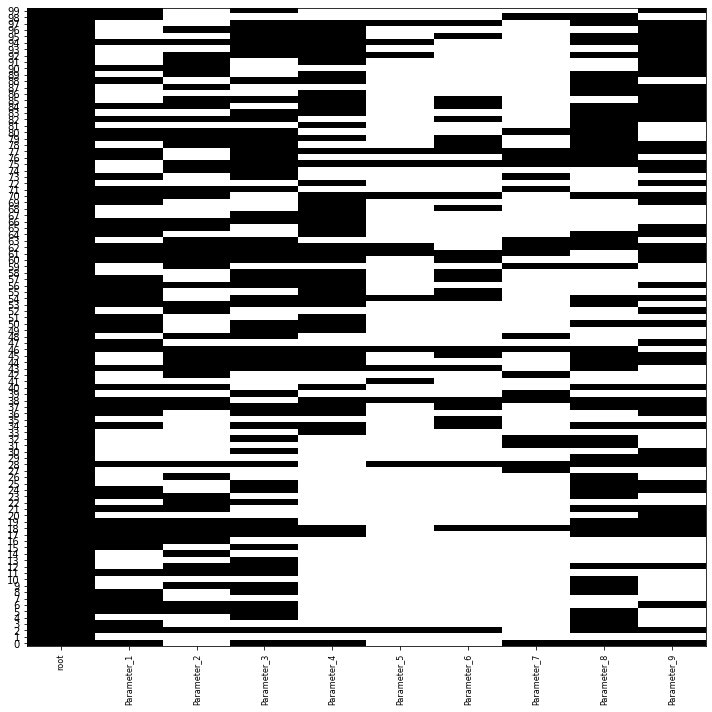

In [3]:
sampler = Sampler(DistanceSamplingStrategy(vm))
logging.getLogger().setLevel(logging.DEBUG)
#sampler_test = Sampler(FromTestsSamplingStrategy(vm, test_strategy))
sampler_test = Sampler(DistanceSamplingStrategy(vm))
tester = Tester(test_strategy)
x_test, y_test, samples_test = get_samples_with_results_full(sampler_test, tester, 100)
create_sample_distribution_graph(samples_test, vm)

In [4]:
group_size = 5
strategy = IndependentFeatureGroupSamplingStrategy(vm, group_size=group_size) #, load_mutex="./result/tmp/syn-1000-pre.json")

DEBUG:IndependentFeatureGroupSamplingStrategy:Generating mutex graph
DEBUG:root:Start generating mutex graph sequentially
DEBUG:root:Time 0.02449774742126465
DEBUG:IndependentFeatureGroupSamplingStrategy:Feature model Information: ------
DEBUG:IndependentFeatureGroupSamplingStrategy:Mutexes: []
DEBUG:IndependentFeatureGroupSamplingStrategy:Optional features: {'Parameter_4', 'Parameter_8', 'Parameter_1', 'Parameter_5', 'Parameter_7', 'Parameter_9', 'Parameter_6', 'Parameter_2', 'Parameter_3'}
DEBUG:IndependentFeatureGroupSamplingStrategy:Independent features: {'Parameter_4', 'Parameter_8', 'Parameter_1', 'Parameter_5', 'Parameter_7', 'Parameter_9', 'Parameter_6', 'Parameter_2', 'Parameter_3'} 



DEBUG:IndependentFeatureGroupSamplingStrategy:Get sample with groups size 5
DEBUG:IndependentFeatureGroupSamplingStrategy:Searching for group 0
DEBUG:IndependentFeatureGroupSamplingStrategy:Group generation: 0.0073299407958984375s
DEBUG:IndependentFeatureGroupSamplingStrategy:Searching for group 1
DEBUG:IndependentFeatureGroupSamplingStrategy:Group generation: 0.005460500717163086s
DEBUG:IndependentFeatureGroupSamplingStrategy:Searching for group 2
DEBUG:IndependentFeatureGroupSamplingStrategy:Group generation: 0.005939483642578125s
DEBUG:IndependentFeatureGroupSamplingStrategy:Searching for group 3
DEBUG:IndependentFeatureGroupSamplingStrategy:Group generation: 0.009857654571533203s
DEBUG:IndependentFeatureGroupSamplingStrategy:Searching for group 4
DEBUG:IndependentFeatureGroupSamplingStrategy:Group generation: 0.010219335556030273s
DEBUG:IndependentFeatureGroupSamplingStrategy:Grouping generation: 0.0586237907409668s
DEBUG:IndependentFeatureGroupSamplingStrategy:Get sample with grou

[[[1, 1, 0, 0, 0, 0, 0, 0, 1, 0], [1, 0, 1, 1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 1, 0, 0, 1], [1, 0, 0, 0, 1, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 1, 0, 0]], [[1, 0, 0, 1, 0, 0, 0, 0, 1, 0], [1, 1, 0, 0, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 1, 1, 0, 0, 0], [1, 0, 1, 0, 1, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 0, 0, 0, 0]], [[1, 1, 0, 1, 0, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 1, 0, 1, 0, 0, 0], [1, 0, 0, 0, 0, 1, 0, 0, 1, 0], [1, 0, 0, 1, 0, 0, 0, 0, 0, 0]], [[1, 1, 1, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 1, 1], [1, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 0, 1, 0, 1, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 0]], [[1, 0, 1, 0, 0, 0, 0, 0, 1, 0], [1, 0, 0, 1, 0, 0, 0, 0, 0, 1], [1, 1, 0, 0, 1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 1, 1, 0, 0], [1, 0, 0, 0, 0, 1, 0, 0, 0, 0]]] [[313, 194, 208, 200, 196], [308, 205, 205, 197, 198], [197, 202, 203, 313, 196], [199, 316, 200, 197, 199], [310, 200, 200, 200, 201]] [[['Parameter_1', 'Parameter_8', 'root'], ['Parameter

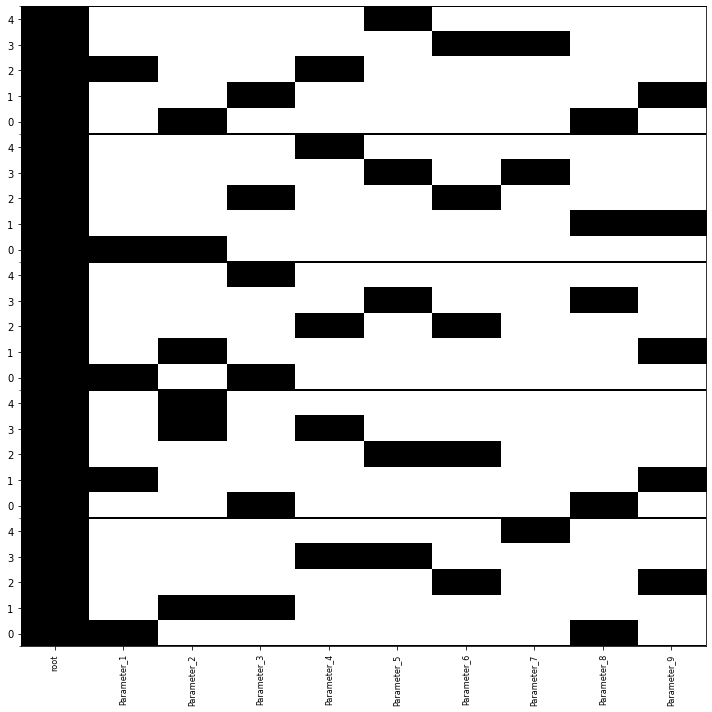

In [5]:

grouped_sampler = Sampler(strategy)
grouped_tester = GroupedTester(test_strategy)
logging.getLogger().setLevel(logging.DEBUG)
grouped_sampler.reset()

x, y, samples = get_samples_with_results_full(grouped_sampler, grouped_tester, 5)
print(x,y,samples)
#display((make_df_representation(x, y)))
create_sample_distribution_graph_groupings(samples, vm, [])

In [6]:
df = make_df_representation(x, y)
df = df[df.index % group_size == 0]
from scipy.spatial.distance import pdist, squareform

distances = pdist(df.values, metric='hamming')
dist_matrix = squareform(distances)
display(pandas.DataFrame(dist_matrix))

,0,1,2,3,4
0,0.000000,0.272727,0.272727,0.272727,0.272727
1,0.272727,0.000000,0.272727,0.454545,0.272727
2,0.272727,0.272727,0.000000,0.272727,0.454545
3,0.272727,0.454545,0.272727,0.000000,0.272727
4,0.272727,0.272727,0.454545,0.272727,0.000000


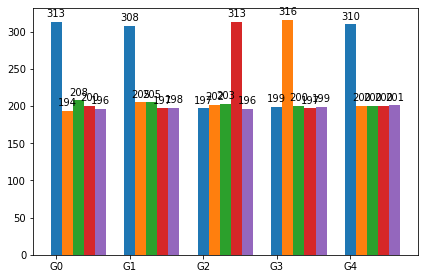

In [7]:
create_grouping_influence_graph(x, y, group_size)

DEBUG:Soeren:Fitting data
DEBUG:Soeren:Determining group sensitivity took 0.15610980987548828.
DEBUG:Soeren:1th influential parameter idx: 8 with 87.84814814814817
DEBUG:Soeren:2th influential parameter idx: 9 with -15.521481481481464
DEBUG:Soeren:3th influential parameter idx: 7 with -26.485185185185163
DEBUG:Soeren:4th influential parameter idx: 4 with -24.35185185185183
DEBUG:Soeren:5th influential parameter idx: 3 with -20.372962962962948
DEBUG:Soeren:6th influential parameter idx: 2 with -12.085493827160485
DEBUG:Soeren:7th influential parameter idx: 5 with -8.354074074074067
DEBUG:Soeren:8th influential parameter idx: 1 with -4.455123456790119
DEBUG:Soeren:9th influential parameter idx: 6 with -1.9347407407407364
DEBUG:Soeren:Interaction between (8, 9)
DEBUG:Soeren:12th influential parameter idx: 45 with 19.521481481481466
DEBUG:Soeren:Interaction between (5, 6)
DEBUG:Soeren:13th influential parameter idx: 36 with -8.863037037037028
DEBUG:Soeren:Interaction between (1, 2)
DEBUG:S

[37.6927180332056, 2103.7490109912796, 0.3235627886340956, 0.14366263881017927]


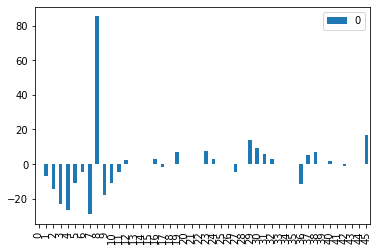

In [8]:
from learning.grouped_learning_with import Soeren

berta = Soeren(vm, group_size)
logging.getLogger().setLevel(logging.DEBUG)
berta.fit(x, y)
co = pandas.DataFrame(berta.model.coef_)
ax = co.transpose().plot.bar()
# ax.set_xticklabels(vm.get_features())
y_predicted = berta.predict(x_test)
metrics = get_regression_metricts(y_test, y_predicted)
comp = pandas.DataFrame()
comp['Test'] = y_test[:50]
comp['Predicted'] = y_predicted[:50]
#comp.plot.bar()
#display(comp)
print(metrics)

DEBUG:Berta:Fitting data
DEBUG:Berta:Determining group sensitivity took 0.07840991020202637.


,0,1,2,3,4,5,6,7,8,9
0,NaN,88.848148,NaN,NaN,NaN,NaN,NaN,NaN,88.848148,NaN
1,NaN,NaN,-30.151852,-30.151852,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,-16.151852,NaN,NaN,-16.151852
3,NaN,NaN,NaN,NaN,-24.151852,-24.151852,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-28.151852,NaN,NaN
5,NaN,NaN,NaN,83.848148,NaN,NaN,NaN,NaN,83.848148,NaN
6,NaN,-19.151852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-19.151852
7,NaN,NaN,NaN,NaN,NaN,-19.151852,-19.151852,NaN,NaN,NaN
8,NaN,NaN,-27.151852,NaN,-27.151852,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,-26.151852,NaN,NaN,NaN,NaN,NaN,NaN,NaN


DEBUG:Berta:1th influential parameter idx: 8 with 87.84814814814817
DEBUG:Berta:2th influential parameter idx: 9 with -15.521481481481464
DEBUG:Berta:3th influential parameter idx: 7 with -26.485185185185163
DEBUG:Berta:4th influential parameter idx: 4 with -24.35185185185183
DEBUG:Berta:5th influential parameter idx: 3 with -20.372962962962948
DEBUG:Berta:6th influential parameter idx: 2 with -12.085493827160485
DEBUG:Berta:7th influential parameter idx: 5 with -8.354074074074067
DEBUG:Berta:8th influential parameter idx: 1 with -4.455123456790119
DEBUG:Berta:9th influential parameter idx: 6 with -1.9347407407407364
DEBUG:Berta:Stepwise analysis took 0.26647377014160156.
INFO:Berta:Fitting data took 0.36599230766296387.


[30.059870919067222, 1414.6283407678138, 0.5451419133419986, 0.10859843767195886]


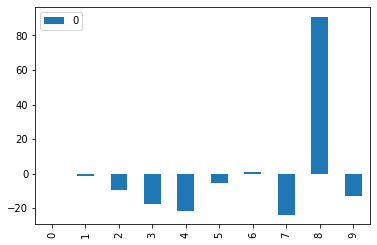

In [9]:
berta = Berta(vm, group_size)
logging.getLogger().setLevel(logging.DEBUG)
berta.fit(x, y)
co = pandas.DataFrame(berta.model.coef_)
ax = co.transpose().plot.bar()
# ax.set_xticklabels(vm.get_features())
y_predicted = berta.predict(x_test)
metrics = get_regression_metricts(y_test, y_predicted)
comp = pandas.DataFrame()
comp['Test'] = y_test[:50]
comp['Predicted'] = y_predicted[:50]
#comp.plot.bar()
#display(comp)
print(metrics)